## Now that HCF script has been fully developed, implement it here and take a look at outputs.
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 30 Oct 2020 

In [1]:
# Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import datetime 
import time 
from ComputeHCF import HCF 
from joblib import Parallel, delayed 

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## 1. Read in data

<b>What data do we need?</b> <br>
Vertical profiles of: temperature (T), specific humidity (Q), geopotential height (zg in CESM2, Z3 in other runs), and pressure (P). <br>
In addition, need lowest level temperature, specfic humidity, height, and pressure - so basically T2m, Q2m, PSfc, and 2m height. <br><br>
<b>Units:</b><br>
Temperature --> K <br>
Height      --> m <br>
Sp. Humidity -> kg/kg <br>
Pressure    --> Pa  <br><br>



### 1.1 Read in data from hourly simulation I ran with CESM2

In [3]:
# dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/hrSim_CONUS/'

# Tpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrT-UTCsel.nc'
# Zpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrZ3-UTCsel.nc'
# Qpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrQ-UTCsel.nc'
# Ppr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrP-levels-UTCsel.nc'

# # ----------- Open files -------------
# print('Read in profile of...')
# Tpr = xr.open_dataset(Tpr_file, decode_times=True)
# Tpr['time'] = Tpr.indexes['time'].to_datetimeindex()
# print('.....T')
# Zpr = xr.open_dataset(Zpr_file, decode_times=True)
# Zpr['time'] = Zpr.indexes['time'].to_datetimeindex()
# print('.....Z3')
# Qpr = xr.open_dataset(Qpr_file, decode_times=True)
# Qpr['time'] = Qpr.indexes['time'].to_datetimeindex()
# print('.....Q')
# Ppr = xr.open_dataset(Ppr_file, decode_times=True)
# Ppr['time'] = Ppr.indexes['time'].to_datetimeindex()
# print('.....P')

# # ----------- Isolate 1980 in Ppr -----
# dates1980     = pd.DatetimeIndex(Tpr['time'].values)
# datesPpr      = pd.DatetimeIndex(Ppr['time'].values)
# iTimes        = np.where( (datesPpr>=(dates1980[0])) & (datesPpr<=dates1980[-1]) )[0]

# Ppr_sel       = Ppr.isel(time=iTimes)


This is all a bit easier to work with if everything's in it's own xarray DataSet

In [3]:
# ds_Full = Tpr 
# ds_Full['Qpr'] = (('time','lev','lat','lon'), Qpr.Q)
# ds_Full['Zpr'] = (('time','lev','lat','lon'), Zpr.Z3)
# ds_Full['Ppr'] = (('time','lev','lat','lon'), Ppr_sel.PRESSURE)


In [4]:
# # Pick out 12 UTC only (early morning for most of US)
# ds_utc12 = ds_Full.where( ds_Full.UTC_hr==12.0 , drop=True )


In [5]:
# lat = ds_utc12.lat.values
# lon = ds_utc12.lon.values


In [6]:
# # Isolate UTC times 
# UTC_hr_CESM2  = ds_utc12.UTC_hr.values
# UTC_day_CESM2 = ds_utc12.UTC_day.values
# UTC_mon_CESM2 = ds_utc12.UTC_mon.values
# UTC_yr_CESM2  = ds_utc12.UTC_yr.values

### 1.2 Read in 3-hrly data from Isla's run with CAM6+CLM4.5

In [2]:
# Set up strings used to define/access each file 
dataDir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM45/'

fileStart  = 'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.'
profileEnd = '_conusAllTimes-VertProfiles.nc'
pressEnd   = '_conus-Pressure-UTCtimes.nc'

years = np.arange(1980,1983).astype(str)

# Read in yearly files 
for iYr in range(len(years)): 
    # Set up file names 
    fileName_profile = dataDir+fileStart+years[iYr]+profileEnd
    fileName_press   = dataDir+fileStart+years[iYr]+pressEnd
    
    # Open files and save to larger arrays 
    with xr.open_dataset(fileName_profile, decode_times=True) as profileDS:
        profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
        profileDS
        
        if iYr==0:
            fullDS_profiles = profileDS
        else: 
            fullDS_profiles = xr.concat([fullDS_profiles, profileDS], dim='time')

            
    with xr.open_dataset(fileName_press, decode_times=True) as pressDS:
        pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()
        
        if iYr==0:
            fullDS_pressure = pressDS
        else: 
            fullDS_pressure = xr.concat([fullDS_pressure,pressDS], dim='time')
    
    print('Done with reading in files for year %s' % years[iYr])


<ipython-input-2-218dcec84f2e>:18: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
<ipython-input-2-218dcec84f2e>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()


Done with reading in files for year 1980
Done with reading in files for year 1981
Done with reading in files for year 1982


In [3]:
ds_CLM45 = fullDS_profiles
ds_CLM45['PRESSURE'] = (('time','lev','lat','lon'), fullDS_pressure.PRESSURE)
ds_CLM45['UTC_hr'] = (('time'), fullDS_pressure.UTC_hr)
ds_CLM45['UTC_day'] = (('time'), fullDS_pressure.UTC_day)
ds_CLM45['UTC_mon'] = (('time'), fullDS_pressure.UTC_mon)
ds_CLM45['UTC_yr'] = (('time'), fullDS_pressure.UTC_yr)

# # ----------- Isolate 1980 for testing -----
# i1980        = np.where(ds_CLM45.UTC_yr==1980)[0]
# ds1980_CLM45 = ds_CLM45.isel(time=i1980)


In [4]:
# Pick out 12 UTC only (early morning for most of US)
ds_utc12_CLM45 = ds_CLM45.where( ds_CLM45.UTC_hr==12.0, drop=True )


In [5]:
# Isolate UTC times 
UTC_hr_CLM45  = ds_utc12_CLM45.UTC_hr.values
UTC_day_CLM45 = ds_utc12_CLM45.UTC_day.values
UTC_mon_CLM45 = ds_utc12_CLM45.UTC_mon.values
UTC_yr_CLM45  = ds_utc12_CLM45.UTC_yr.values


In [6]:
# Also get lat and lon
lat = ds_utc12_CLM45.lat.values
lon = ds_utc12_CLM45.lon.values


### 1.3 Read in 3-hrly data from Isla's run with CAM6+CLM5 (for consistency, would rather use this)

In [7]:
# Set up strings used to define/access each file 
dataDir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM5/'

fileStart  = 'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.'
profileEnd = '_conusAllTimes-VertProfiles.nc'
pressEnd   = '_conus-Pressure-UTCtimes.nc'

years = np.arange(1980,1983).astype(str)

# Read in yearly files 
for iYr in range(len(years)): 
    # Set up file names 
    fileName_profile = dataDir+fileStart+years[iYr]+profileEnd
    fileName_press   = dataDir+fileStart+years[iYr]+pressEnd
    
    # Open files and save to larger arrays 
    with xr.open_dataset(fileName_profile, decode_times=True) as profileDS:
        profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
        profileDS
        
        if iYr==0:
            fullDS_profiles = profileDS
        else: 
            fullDS_profiles = xr.concat([fullDS_profiles, profileDS], dim='time')

            
    with xr.open_dataset(fileName_press, decode_times=True) as pressDS:
        pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()
        
        if iYr==0:
            fullDS_pressure = pressDS
        else: 
            fullDS_pressure = xr.concat([fullDS_pressure,pressDS], dim='time')
    
    print('Done with reading in files for year %s' % years[iYr])


<ipython-input-7-ebf64350df9a>:18: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
<ipython-input-7-ebf64350df9a>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()


Done with reading in files for year 1980
Done with reading in files for year 1981
Done with reading in files for year 1982


In [8]:
ds_CLM5 = fullDS_profiles
ds_CLM5['PRESSURE'] = (('time','lev','lat','lon'), fullDS_pressure.PRESSURE)
ds_CLM5['UTC_hr'] = (('time'), fullDS_pressure.UTC_hr)
ds_CLM5['UTC_day'] = (('time'), fullDS_pressure.UTC_day)
ds_CLM5['UTC_mon'] = (('time'), fullDS_pressure.UTC_mon)
ds_CLM5['UTC_yr'] = (('time'), fullDS_pressure.UTC_yr)


In [9]:
# Pick out 12 UTC only (early morning for most of US)
ds_utc12_CLM5 = ds_CLM5.where( ds_CLM5.UTC_hr==12.0, drop=True )

# Isolate UTC times 
UTC_hr_CLM5  = ds_utc12_CLM5.UTC_hr.values
UTC_day_CLM5 = ds_utc12_CLM5.UTC_day.values
UTC_mon_CLM5 = ds_utc12_CLM5.UTC_mon.values
UTC_yr_CLM5  = ds_utc12_CLM5.UTC_yr.values


## 2. Compute HCF for each grid point. 

Do note though that this is not the most *efficient* code, by any means. There may be ways to speed this up though, and parallel processing should certainly be do-able as well, since each profile is treated independently. 

In [1]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Qpr'
# Zname = 'Zpr'
# Pname = 'Ppr'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12.lev)

# # Define dimensions 
# nLat  = len(ds_utc12.lat)
# nLon  = len(ds_utc12.lon)
# nTime = len(ds_utc12.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):
            
#             # Pick out specific point and time period 
#             DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()
            
#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])
            
#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 
                                                                      
#     print('Done with lat %i of %i ' % (iLat, nLat))
        

# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))


Since computing HCF at each grid point and day can take so long, it's best to only run the above loops once. From there, you can save the output for each variable into a pickle file (a bit easier to work with in python than a full netCDF file or anything like that. <br> 
Alternatively, in the implementation used here, you can first place all the variables into a single xarray dataset again, and save that to a netCDF file. 

In [20]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables_1980.nc'
# HCF_ds.to_netcdf(savePath, mode='w')


Now we can just load in the netCDF file created above (or more files as well, as necessary):

In [11]:
# # Read in netCDF file containing all the HCF variables previously computed... 
# filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables_1980.nc'
# HCFvars  = xr.open_dataset(filePath, decode_times=True)


### 2.1 Compute HCF for CAM6+CLM4.5 simulation

In [10]:
# When converting to a dataframe, need to only have relevent dimension included in dataset. Otherwise,
#   the function to convert to DF will create extra entries along dimensions that things like temperature and 
#   humidity don't depend on, breaking the below HCF calculation cell. 

ds_utc12_CLM45 = ds_utc12_CLM45.drop('time_bnds')  # Want to get rid of nbnd dimension 

# Want to also drop ilev dimension
ds_utc12_CLM45 = ds_utc12_CLM45.drop('hyai')
ds_utc12_CLM45 = ds_utc12_CLM45.drop('hybi') 
ds_utc12_CLM45 = ds_utc12_CLM45.drop('ilev')

In [2]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Q'
# Zname = 'Z3'
# Pname = 'PRESSURE'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12_CLM45.lev)

# # Define dimensions 
# nLat  = len(ds_utc12_CLM45.lat)
# nLon  = len(ds_utc12_CLM45.lon)
# nTime = len(ds_utc12_CLM45.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):

#             # Pick out specific point and time period 
#             DF = ds_utc12_CLM45.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()

#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])

#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 

#     print('Done with lat %i of %i ' % (iLat, nLat))


# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))



In [11]:
# # Set lat and lon as well: 
# lat = ds_utc12_CLM45.lat.values
# lon = ds_utc12_CLM45.lon.values

In [12]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM4p5_1980-1982.nc'
# HCF_ds.to_netcdf(savePath, mode='w')



In [11]:
# Read in netCDF file containing all the HCF variables previously computed... 
filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM4p5_1980-1982.nc'
HCFvars_CLM45  = xr.open_dataset(filePath, decode_times=True)


### 2.2 Compute for CAM6+CLM5 run from Isla

In [12]:
# When converting to a dataframe, need to only have relevent dimension included in dataset. Otherwise,
#   the function to convert to DF will create extra entries along dimensions that things like temperature and 
#   humidity don't depend on, breaking the below HCF calculation cell. 

ds_utc12_CLM5 = ds_utc12_CLM5.drop('time_bnds')  # Want to get rid of nbnd dimension 

# Want to also drop ilev dimension
ds_utc12_CLM5 = ds_utc12_CLM5.drop('hyai')
ds_utc12_CLM5 = ds_utc12_CLM5.drop('hybi') 
ds_utc12_CLM5 = ds_utc12_CLM5.drop('ilev')

# Set lat and lon as well: 
lat = ds_utc12_CLM5.lat.values
lon = ds_utc12_CLM5.lon.values


In [3]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Q'
# Zname = 'Z3'
# Pname = 'PRESSURE'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12_CLM5.lev)

# # Define dimensions 
# nLat  = len(ds_utc12_CLM5.lat)
# nLon  = len(ds_utc12_CLM5.lon)
# nTime = len(ds_utc12_CLM5.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):

#             # Pick out specific point and time period 
#             DF = ds_utc12_CLM5.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()

#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])

#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 

#     print('Done with lat %i of %i ' % (iLat, nLat))


# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))


In [50]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM5-islarun_1980-1982.nc'
# HCF_ds.to_netcdf(savePath, mode='w')


In [13]:
# Read in netCDF file containing all the HCF variables previously computed... 
filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM5-islarun_1980-1982.nc'
HCFvars_CLM5  = xr.open_dataset(filePath, decode_times=True)


In [168]:
HCFvars_CLM5

<xarray.Dataset>
Dimensions:  (lat: 43, lon: 65, time: 1095)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1982-12-31T12:00:00
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 57.02 57.96 58.9 59.84
  * lon      (lon) float64 220.0 221.2 222.5 223.8 ... 296.2 297.5 298.8 300.0
Data variables:
    TBM      (time, lat, lon) float64 294.2 294.2 294.3 ... 265.0 265.2 265.4
    BCLH     (time, lat, lon) float64 ...
    BCLP     (time, lat, lon) float64 ...
    TDEF     (time, lat, lon) float64 ...
    TRAN_H   (time, lat, lon) float64 ...
    TRAN_P   (time, lat, lon) float64 ...
    TRAN_T   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SHDEF_M  (time, lat, lon) float64 ...
    LHDEF_M  (time, lat, lon) float64 ...
    EADV_M   (time, lat, lon) float64 ...

## 3. Now plot some of these variables 

In [14]:
# Pull out dimensions
lat  = HCFvars_CLM5.lat.values
lon  = HCFvars_CLM5.lon.values
time = HCFvars_CLM5.time.values


In [15]:
# Get summer values only
iJJA_CLM5   = np.where( (UTC_mon_CLM5>=6) & (UTC_mon_CLM5<=8) )[0]
iJJA_CLM45  = np.where( (UTC_mon_CLM45>=6) & (UTC_mon_CLM45<=8) )[0]

thetaBM_CLM5  = HCFvars_CLM5.TBM.values[iJJA_CLM5,:,:]
thetaBM_CLM45 = HCFvars_CLM45.TBM.values[iJJA_CLM45,:,:]

thetaAdv_CLM5  = HCFvars_CLM5.TRAN_T.values[iJJA_CLM5,:,:]
thetaAdv_CLM45 = HCFvars_CLM45.TRAN_T.values[iJJA_CLM45,:,:]


In [16]:
# ----- Also apply a land mask (based on same resolution in another sim) -----

# Read in single history file to get lat/lon and masks 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
latGlobal = testDF.lat
lonGlobal = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Pick out CONUS 
ilatConus = np.where((latGlobal>=np.min(lat)) & (latGlobal<=np.max(lat)))[0]
ilonConus = np.where((lonGlobal>=np.min(lon)) & (lonGlobal<=np.max(lon)))[0]
landMask = landMask[ilatConus,:]
landMask = landMask[:,ilonConus]
np.shape(landMask)

# Now apply that land mask to above calculated variables 
thetaBM_CLM5  = thetaBM_CLM5*landMask
thetaBM_CLM45 = thetaBM_CLM45*landMask
thetaAdv_CLM5  = thetaAdv_CLM5*landMask
thetaAdv_CLM45 = thetaAdv_CLM45*landMask



### 3.1 Summer-mean theta_BM (buoyant mixing potential temperature) 

I'd like the colors used to match Ahemd's paper exactly if possible, so using custom function again below (which I absolutely did not right but nabbed from the internet; problem is, I don't remember where!) 

In [17]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap



In [18]:
### Create a list of RGB tuples
colorsList_theta = [(  9,0,146), 
                     (20,2,228),
                     (20,49,245),
                     (71,159,247),
                     (111,240,252),
                     (117,252,172),
                     (124,252,76),
                     (253,241,80),
                     (241,160,57),
                     (234,58,36),
                     (233,51,35),
                     (150,28,19)] # This example uses the 8-bit RGB

my_cmap_Theta = make_cmap(colorsList_theta, bit=True)


In [19]:
bounds = np.arange(297,334,3)
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


<ipython-input-18-7ba9e5ad2829>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM5, axis=0),


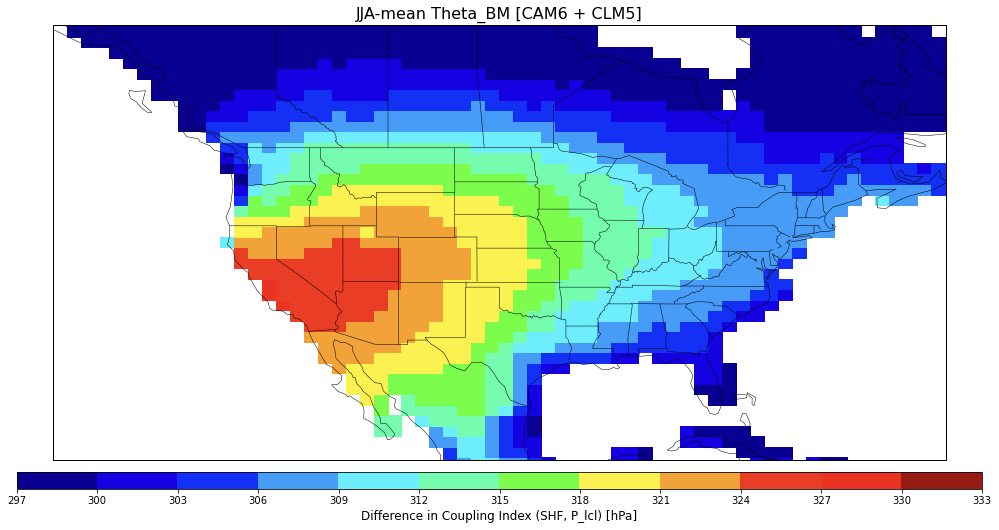

In [18]:
# Plot mean Theta_BM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM5, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')




<ipython-input-19-9fea2e9d9357>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM45, axis=0),


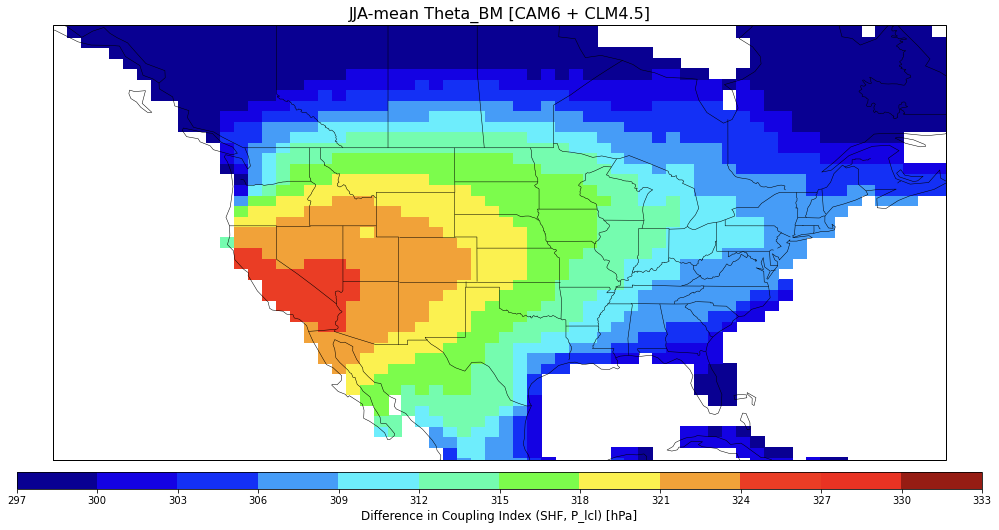

In [19]:
# Plot mean TBM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM45, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM6 + CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')





### 3.2 Summer mean theta-advantage (transition from moisture input to BL growth advantage) 


<ipython-input-20-6916531b768c>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM5, axis=0),


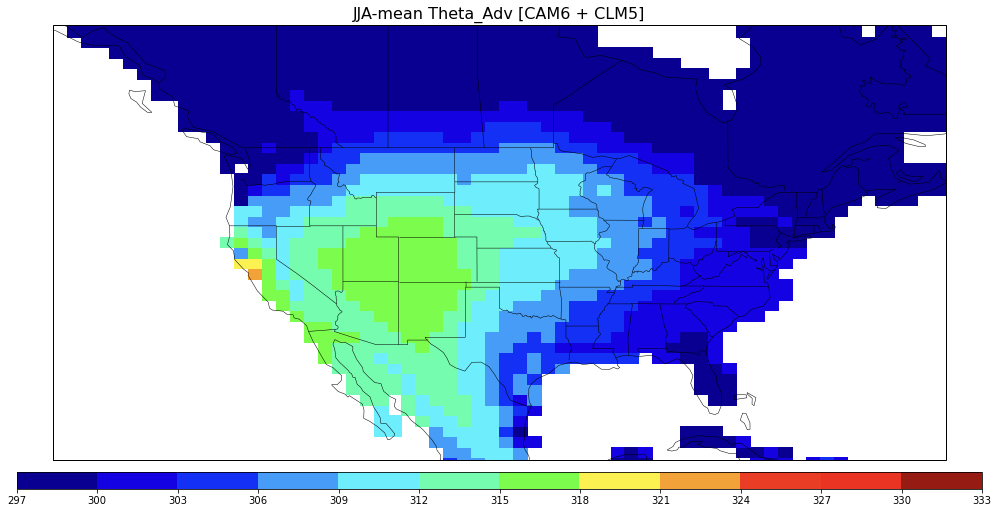

In [20]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM5, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_Adv [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')



<ipython-input-21-69c01d73cb80>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM45, axis=0),


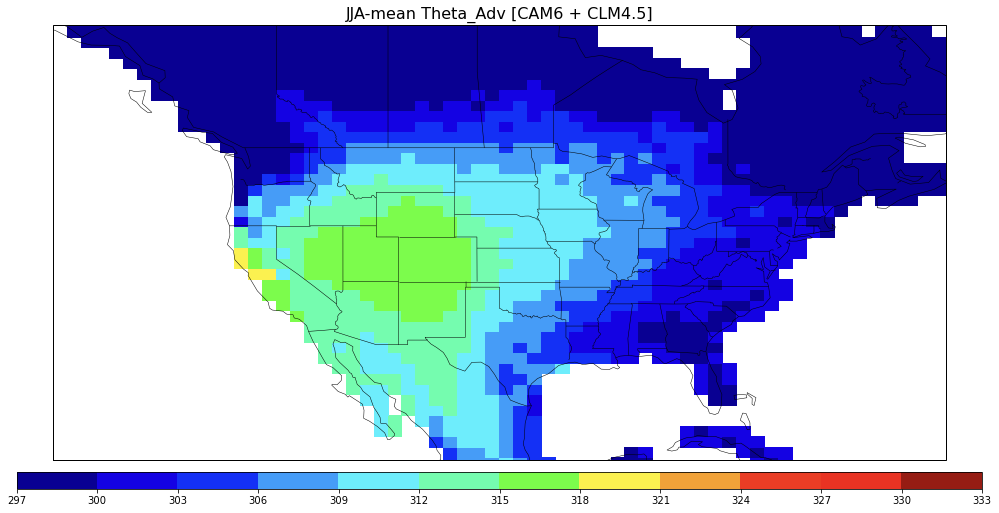

In [21]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM45, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_Adv [CAM6 + CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')






## 4. Read in longer  in longer timeseries of theta - get distribution of daily maximum theta_2m 

In [20]:
# -----------------------------
# 20 years of theta, CLM5+CAM6 
# -----------------------------
CLM5dir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM5/'
clm5_file1 = CLM5dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.1979-1989_sfcPotentialTemperature.nc'
clm5_file2 = CLM5dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.1990-1999_sfcPotentialTemperature.nc'

with xr.open_dataset(clm5_file1,decode_times=True) as clm5_ds1: 
    clm5_ds1['time'] =  clm5_ds1.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(clm5_file2,decode_times=True) as clm5_ds2: 
    clm5_ds2['time'] =  clm5_ds2.indexes['time'].to_datetimeindex()
    
clm5_thetaDS = xr.concat([clm5_ds1, clm5_ds2], dim='time')
print('CAM6+CLM5 theta files saved to: clm5_thetaDS')

# -----------------------------
# 20 years of theta, CLM45+CAM6
# -----------------------------
CLM45dir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM45/'

clm45_file1 = CLM45dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.1979-1989_sfcPotentialTemperature.nc'
clm45_file2 = CLM45dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.1990-1999_sfcPotentialTemperature.nc'

with xr.open_dataset(clm45_file1,decode_times=True) as clm45_ds1: 
    clm45_ds1['time'] =  clm45_ds1.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(clm45_file2,decode_times=True) as clm45_ds2: 
    clm45_ds2['time'] =  clm45_ds2.indexes['time'].to_datetimeindex()
    
clm45_thetaDS = xr.concat([clm45_ds1, clm45_ds2], dim='time')
print('CAM6+CLM5 theta files saved to: clm45_thetaDS')


<ipython-input-20-99ab74c0a646>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_ds1['time'] =  clm5_ds1.indexes['time'].to_datetimeindex()
<ipython-input-20-99ab74c0a646>:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_ds2['time'] =  clm5_ds2.indexes['time'].to_datetimeindex()


CAM6+CLM5 theta files saved to: clm5_thetaDS


<ipython-input-20-99ab74c0a646>:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45_ds1['time'] =  clm45_ds1.indexes['time'].to_datetimeindex()
<ipython-input-20-99ab74c0a646>:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45_ds2['time'] =  clm45_ds2.indexes['time'].to_datetimeindex()


CAM6+CLM5 theta files saved to: clm45_thetaDS


In [21]:
# Limit years to be 1980-1999 (ignore 1979 as spin up)
dates_CLM5  = pd.DatetimeIndex(clm5_thetaDS['time'].values)      # 1: Pull out dates to usable form 
dates_CLM45 = pd.DatetimeIndex(clm45_thetaDS['time'].values)

iTimes_CLM5  = np.where( dates_CLM5.year>=1980 )[0]              # 2: Find indices of times 1980-1999
iTimes_CLM45 = np.where( dates_CLM45.year>=1980)[0]

clm5_thetaDS_timeSel  = clm5_thetaDS.isel(time=iTimes_CLM5)      # 3: Select indices in full datasets 
clm45_thetaDS_timeSel = clm45_thetaDS.isel(time=iTimes_CLM45) 


In [22]:
# Get daily maximum values of theta (have confirmed this works as expected)
dailyMax_CLM5  = clm5_thetaDS_timeSel.resample(time="1D").max()
dailyMax_CLM45 = clm45_thetaDS_timeSel.resample(time="1D").max()


In [23]:
# Get time from the *daily* maximum dataset, otherwise working with 3-hourly stuff still 
dates_CLM5  = pd.DatetimeIndex(dailyMax_CLM5['time'].values)
dates_CLM45 = pd.DatetimeIndex(dailyMax_CLM45['time'].values)


In [24]:
# Select JJA only 
iJJA_CLM5  = np.where( (dates_CLM5.month>=6)  & (dates_CLM5.month<=8) )[0]
iJJA_CLM45 = np.where( (dates_CLM45.month>=6) & (dates_CLM45.month<=8) )[0]

dailyMax_CLM5_JJA  = dailyMax_CLM5.isel(time=iJJA_CLM5)
dailyMax_CLM45_JJA = dailyMax_CLM45.isel(time=iJJA_CLM45)


In [25]:
dailyMax_CLM5_JJA

<xarray.Dataset>
Dimensions:        (lat: 43, lon: 65, time: 1840)
Coordinates:
  * time           (time) datetime64[ns] 1980-06-01 1980-06-02 ... 1999-08-31
  * lat            (lat) float64 20.26 21.2 22.15 23.09 ... 57.96 58.9 59.84
  * lon            (lon) float64 220.0 221.2 222.5 223.8 ... 297.5 298.8 300.0
Data variables:
    THETA_PS_TBOT  (time, lat, lon) float32 292.8132 292.6242 ... 277.92746
    THETA_PS_TREF  (time, lat, lon) float32 293.57724 293.38672 ... 278.23157
    UTC_hr         (time) float64 21.0 21.0 21.0 21.0 ... 21.0 21.0 21.0 21.0
    UTC_day        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    UTC_mon        (time) float64 6.0 6.0 6.0 6.0 6.0 ... 8.0 8.0 8.0 8.0 8.0
    UTC_yr         (time) float64 1.98e+03 1.98e+03 ... 1.999e+03 1.999e+03

### 4.1 Maps of JJA-mean thetaMax, following Fig. 3 of Tawfik et al. (2015):

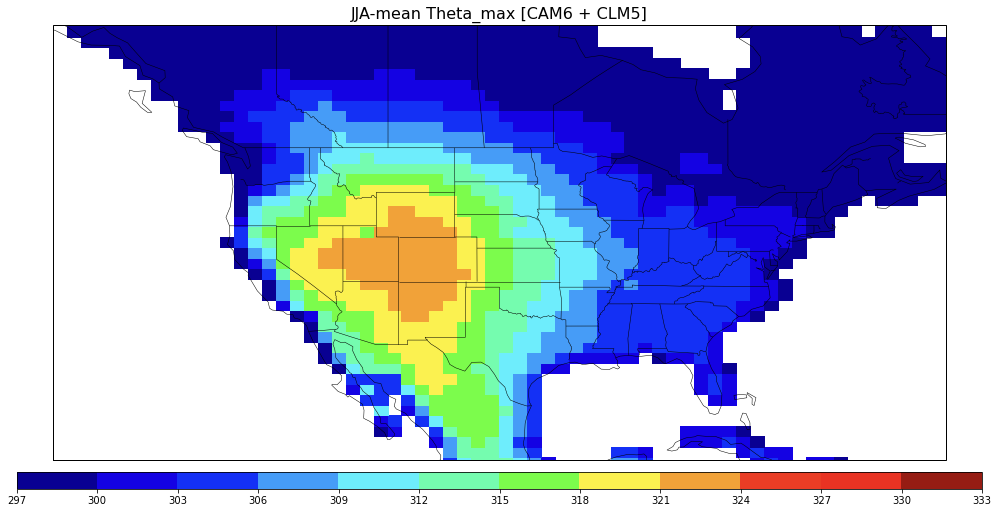

In [49]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(dailyMax_CLM5_JJA.THETA_PS_TREF.values, axis=0)*landMask,
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_max [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)



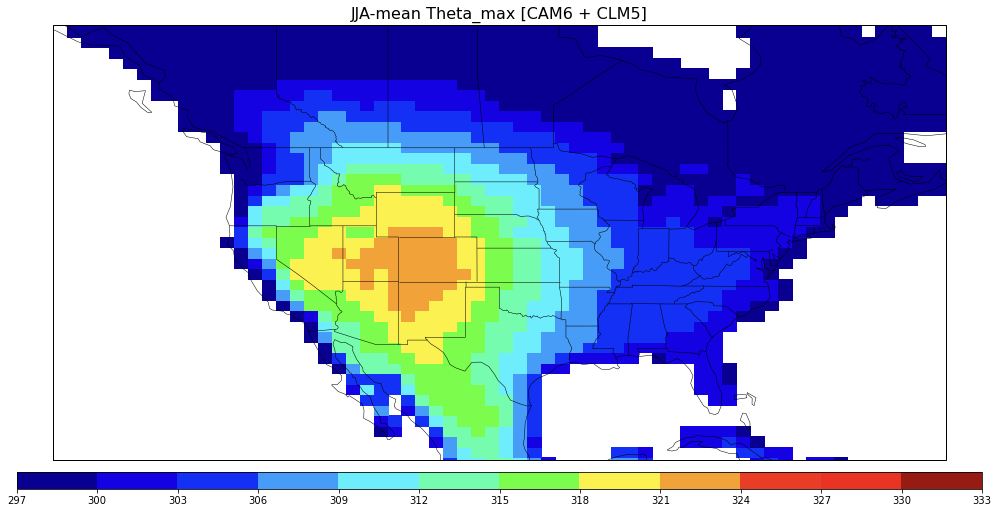

In [50]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(dailyMax_CLM45_JJA.THETA_PS_TREF.values, axis=0)*landMask,
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_max [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)




### 4.2 Take a look at histograms of thetaMax for all JJA points over land

In [173]:
# Set array of bin edges to worry about 
binEdges   = np.arange(260,340,1)
binCenters = binEdges[:-1]+((binEdges[1]-binEdges[0])/2)


In [174]:
# Get PDF over all land gridcells...: 
[hist_clm5,  edges_clm5]  = np.histogram((dailyMax_CLM5_JJA.THETA_PS_TREF.values*landMask).reshape(len(lat)*len(lon)*len(dailyMax_CLM5_JJA.time.values)),   bins=binEdges, density=True)
[hist_clm45, edges_clm45] = np.histogram((dailyMax_CLM45_JJA.THETA_PS_TREF.values*landMask).reshape(len(lat)*len(lon)*len(dailyMax_CLM45_JJA.time.values)), bins=binEdges, density=True)


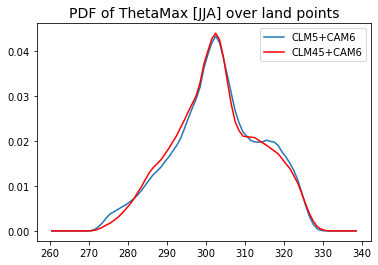

In [175]:
plt.plot(binCenters,hist_clm5,'-')
plt.plot(binCenters, hist_clm45,'r-')
plt.legend(['CLM5+CAM6', 'CLM45+CAM6'])
plt.title('PDF of ThetaMax [JJA] over land points',fontsize=14)

plt.show()


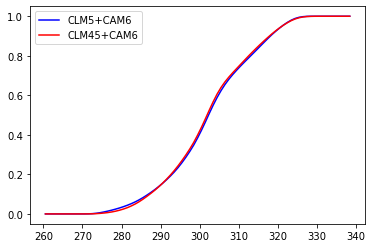

In [176]:
# Also plot cumulative distribution function - 
#  Assuming this is how you get actual probability of convective initiation 

binWidth = binEdges[1]-binEdges[0]

cdf_clm5  = np.cumsum(hist_clm5)*binWidth
cdf_clm45 = np.cumsum(hist_clm45)*binWidth 

plt.plot(binCenters,cdf_clm5,'b-')
plt.plot(binCenters, cdf_clm45,'r-')
plt.legend(['CLM5+CAM6', 'CLM45+CAM6'])


### 4.3 Using PDF of thetaMax per point - what is likelihood of local CI?

In [177]:
# But probably want to do this by point... 
pdf_CLM5 = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)
pdf_CLM45 = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)): 
        dataCLM5  = np.squeeze(dailyMax_CLM5_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        dataCLM45 = np.squeeze(dailyMax_CLM45_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        
        # Compute bin counts 
        [histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)
        [histPoint_clm45, edges_clm45] = np.histogram(dataCLM45,bins=binEdges, density=True)
        
        # Save out to array
        pdf_CLM5[ilat,ilon,:]  = histPoint_clm5
        pdf_CLM45[ilat,ilon,:] = histPoint_clm45
        

/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Now that we have a PDF for all JJA daily maximum potential temperatures for each land gridcell, we need to get the probability of local convective initiation, based on theta_BM. The question I have is *how* exactly that was calculated in Tawfik et al. (2015). There's only one map, and it doesn't say it's a mean of anything; so I don't think the intent is to get a specific percentage change of theta each day and average up. It makes most sense to use a somewhat binary system for each day - is the buoyant mixing potential temperature outside the range of daily maximum 2m theta: yes = 0, no = 1. Then what percentage of all days are 1's as opposed to zeros? That is, what percentage of days have the *possbility* of local convective initiation? 

thetaBM:  310.5683295229828
Bin Center:  [310.5]
probBin:  [0.04511278]


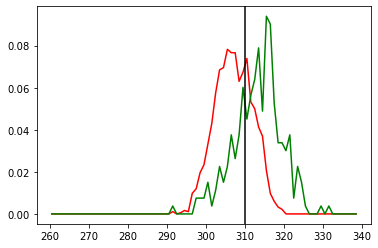

In [178]:
ilat = 20 
ilon = 40 

plt.plot(binCenters, pdf_CLM5[ilat,ilon,:],'r-')

# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,ilat,ilon],bins=binEdges, density=True)
plt.plot(binCenters,histPoint_clm5,'g-')


iTime    = 100
modelVal = thetaBM_CLM5[iTime,ilat,ilon]
iBin     = np.where((binCenters>=modelVal-(binWidth/2)) & (binCenters<=modelVal+(binWidth/2)))[0]
print('thetaBM: ', modelVal)
print('Bin Center: ', binCenters[iBin])
print('probBin: ', histPoint_clm5[iBin]*binWidth)

plt.axvline(edges_clm5[iBin],color='k')


In [179]:
# Upper limit on if local CI is plausible...
CIplaus_CLM5  = np.full([np.shape(thetaBM_CLM5)[0], len(lat),len(lon)], np.nan) 
CIplaus_CLM45 = np.full([np.shape(thetaBM_CLM45)[0], len(lat),len(lon)], np.nan)  

CIplausPct_CLM5  = np.full([np.shape(thetaBM_CLM5)[0], len(lat),len(lon)], np.nan) 

pctDays_CLM5 = np.full([len(lat),len(lon)], np.nan)
pctDays_CLM45 = np.full([len(lat),len(lon)], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        # ------------------------------
        #  Get PDF of thetaMax at point
        # ------------------------------
        dataCLM5  = np.squeeze(dailyMax_CLM5_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        dataCLM45 = np.squeeze(dailyMax_CLM45_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        
        # Compute bin counts 
        [histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)
        [histPoint_clm45, edges_clm45] = np.histogram(dataCLM45,bins=binEdges, density=True)
                
        # Highest bin with any probability:
        validCLM5  = np.where(histPoint_clm5>0)[0]
        validCLM45 = np.where(histPoint_clm45>0)[0]
        
        if len(validCLM5)>0:   
            iPeak_clm5  = binCenters[(np.where(histPoint_clm5>0)[0])[-1]]
            iMin_clm5   = binCenters[(np.where(histPoint_clm5>0)[0])[0]]
            
        if len(validCLM45)>0:
            iPeak_clm45 = binCenters[(np.where(histPoint_clm45>0)[0])[-1]]
            iMin_clm45  = binCenters[(np.where(histPoint_clm45>0)[0])[0]]
        
        # ---------------------------------
        #  Compare thetaBM each day to PDF
        # ---------------------------------
        for iTime in range(np.shape(thetaBM_CLM45)[0]): 
            thetaBM_CLM5_day  = thetaBM_CLM5[iTime,ilat,ilon]
            thetaBM_CLM45_day = thetaBM_CLM45[iTime,ilat,ilon]
            
            if ((len(validCLM5)>0) & (np.isfinite(thetaBM_CLM5_day)==True)): 
                # Assuming binary system...
                if thetaBM_CLM5_day>(iPeak_clm5+binWidth):
                    CIplaus_CLM5[iTime, ilat,ilon] = 0 
                elif ( (thetaBM_CLM5_day<=(iPeak_clm5+binWidth)) & (thetaBM_CLM5_day>=(iMin_clm5-binWidth)) ):
                    CIplaus_CLM5[iTime, ilat,ilon] = 1
                else:
                    CIplaus_CLM5[iTime, ilat,ilon] = -1
                
                # Assuming we use probability from PDF...
                iBin     = np.where((binCenters>=thetaBM_CLM5_day-0.25) & (binCenters<=thetaBM_CLM5_day+0.25))[0]
                if len(iBin)>0:
                    CIplausPct_CLM5[iTime,ilat,ilon] = (histPoint_clm5[iBin]*binWidth)*100.0
                else:
                    CIplausPct_CLM5[iTime,ilat,ilon] = 0.0
                
                    
            if len(validCLM45)>0: 
                if thetaBM_CLM45_day>(iPeak_clm45+binWidth):
                    CIplaus_CLM45[iTime, ilat,ilon] = 0 
                elif ( (thetaBM_CLM45_day<=(iPeak_clm45+binWidth)) & (thetaBM_CLM45_day>=(iMin_clm45-binWidth)) ):
                    CIplaus_CLM45[iTime, ilat,ilon] = 1
                else:
                    CIplaus_CLM45[iTime, ilat,ilon] = -1
                    
        if len(validCLM5)>0: 
            iPlaus                  = np.where(CIplaus_CLM5[:,ilat,ilon]!=0)[0]
            pctDays_CLM5[ilat,ilon] = len(iPlaus)/(np.shape(thetaBM_CLM5)[0])
            
        if len(validCLM45)>0: 
            iPlaus                  = np.where(CIplaus_CLM45[:,ilat,ilon]!=0)[0]
            pctDays_CLM45[ilat,ilon] = len(iPlaus)/(np.shape(thetaBM_CLM45)[0])


/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
<ipython-input-179-5990259089ea>:23: RuntimeWarning: invalid value encountered in greater
  validCLM5  = np.where(histPoint_clm5>0)[0]
<ipython-input-179-5990259089ea>:24: RuntimeWarning: invalid value encountered in greater
  validCLM45 = np.where(histPoint_clm45>0)[0]


/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


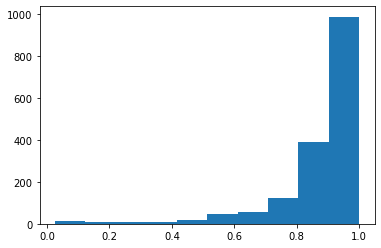

In [180]:
plt.hist(pctDays_CLM5.reshape(len(lat)*len(lon)))
plt.show()

<ipython-input-181-5ca8a5d25907>:1: RuntimeWarning: Mean of empty slice
  plt.hist(np.nanmean(CIplausPct_CLM5,axis=0).reshape(len(lat)*len(lon)))


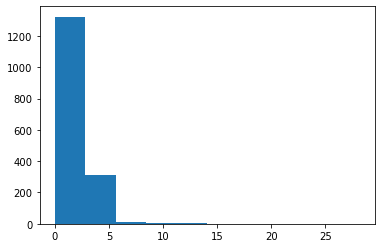

In [181]:
plt.hist(np.nanmean(CIplausPct_CLM5,axis=0).reshape(len(lat)*len(lon)))
plt.show()

<ipython-input-182-f45af39eef07>:1: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(lon,lat,np.nanmean(CIplausPct_CLM5,axis=0),cmap='jet')


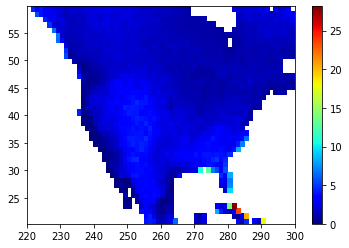

In [182]:
plt.pcolormesh(lon,lat,np.nanmean(CIplausPct_CLM5,axis=0),cmap='jet')
plt.colorbar()

In [183]:
### Create a list of RGB tuples
colorsList_prob = [( 179,179,179), 
                     ( 90, 86,182),
                     ( 10,  0,183),
                     ( 10,100,182),
                     (  0,178,  0),
                     (142,140,  0),
                     (204, 67,  0),
                     (207, 14,  0),
                     (254,  2,  0)] # This example uses the 8-bit RGB

my_cmap_probCI = make_cmap(colorsList_prob, bit=True)

bounds = np.asarray([0,5,15,25,35,45,55,65,75,85])
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


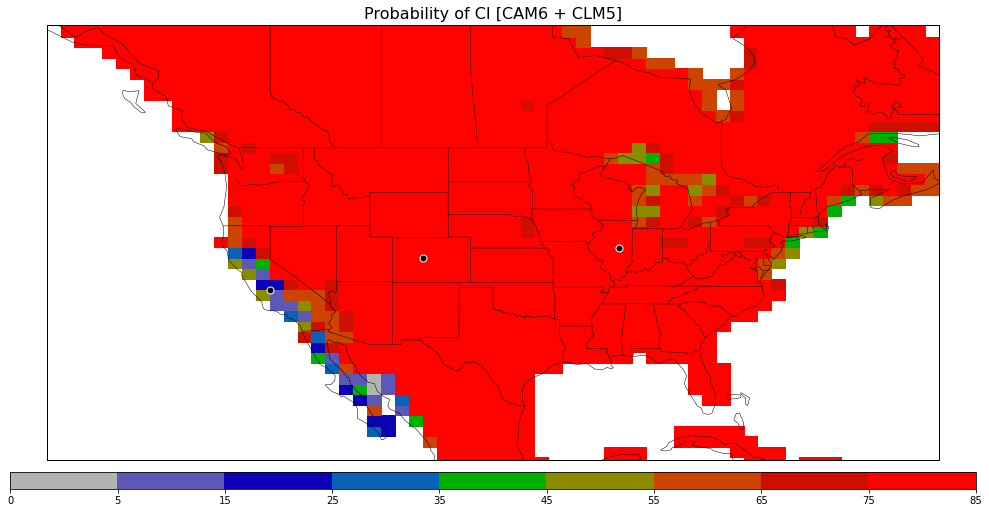

In [184]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, pctDays_CLM5*100,
                             vmin=0,vmax=85,
                             cmap=my_cmap_probCI, norm=norm)

# Additional options 
ax1.set_title('Probability of CI [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_probCI, norm=norm, ticks=bounds, boundaries=bounds)

# Add two points to dig into: 
# CO point
ax1.plot(lon[27],lat[20],'ko',markersize=7,markeredgecolor='white', transform=ccrs.PlateCarree())
# CA point
ax1.plot(lon[16],lat[17],'ko',markersize=7,markeredgecolor='white', transform=ccrs.PlateCarree())
# IL point
ax1.plot(lon[41],lat[21],'ko',markersize=7,markeredgecolor='white', transform=ccrs.PlateCarree())



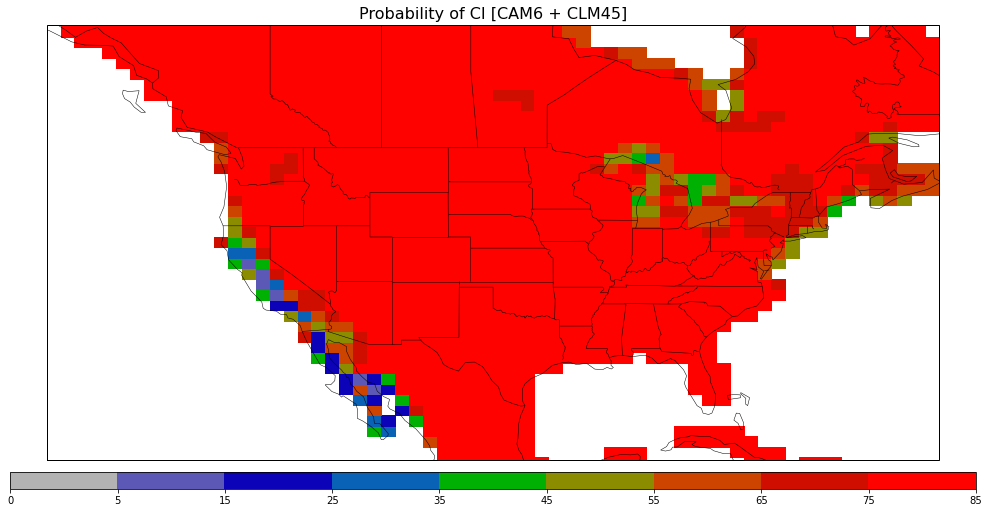

In [185]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, pctDays_CLM45*100,
                             vmin=0,vmax=85,
                             cmap=my_cmap_probCI, norm=norm)

# Additional options 
ax1.set_title('Probability of CI [CAM6 + CLM45]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_probCI, norm=norm, ticks=bounds, boundaries=bounds)



In [186]:
i0 = np.where(CIplaus_CLM5==0)[0]
i1 = np.where(CIplaus_CLM5==1)[0]
ineg1 = np.where(CIplaus_CLM5==-1)[0]

print('Number of points where =0: ', len(i0))
print('Number of points where =1: ', len(i1))
print('Number of points where =-1: ', len(ineg1))



Number of points where =0:  53777
Number of points where =1:  343036
Number of points where =-1:  4046


**Dig into these two points - what's different about them?**

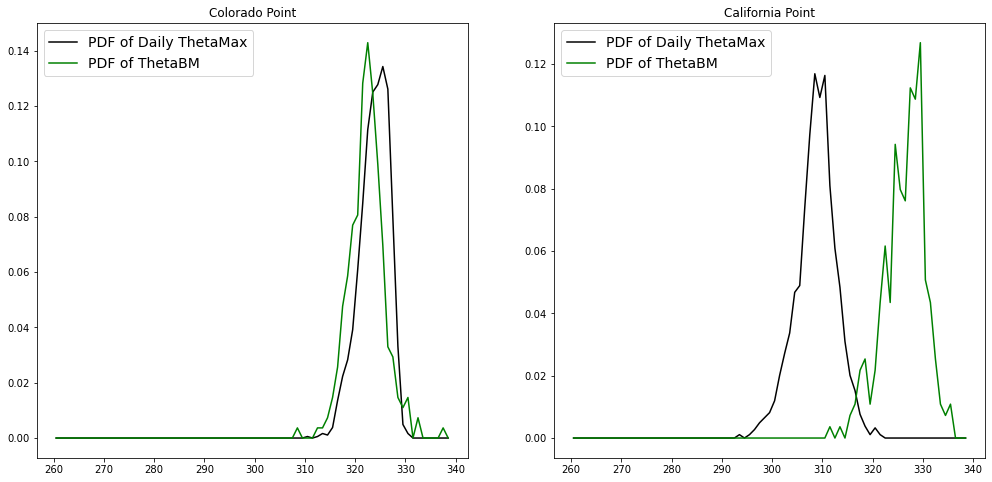

In [187]:
fig, axs = plt.subplots(1,2, figsize=(17, 8))
axs      = axs.ravel()

# Plot distribution of Theta Max at maxed-out region (CO)
axs[0].plot(binCenters, pdf_CLM5[20,27,:],'k-')
axs[0].set_title('Colorado Point')
# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,20,27],bins=binEdges, density=True)
axs[0].plot(binCenters,histPoint_clm5,'g-')
axs[0].legend(['PDF of Daily ThetaMax','PDF of ThetaBM'],fontsize=14)


# Plot distributin of Theta Max at not maxed-out region (CA)
axs[1].plot(binCenters,pdf_CLM5[17,16], 'k-')
axs[1].set_title('California Point')
# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,17,16],bins=binEdges, density=True)
axs[1].plot(binCenters,histPoint_clm5,'g-')
axs[1].legend(['PDF of Daily ThetaMax','PDF of ThetaBM'],fontsize=14)


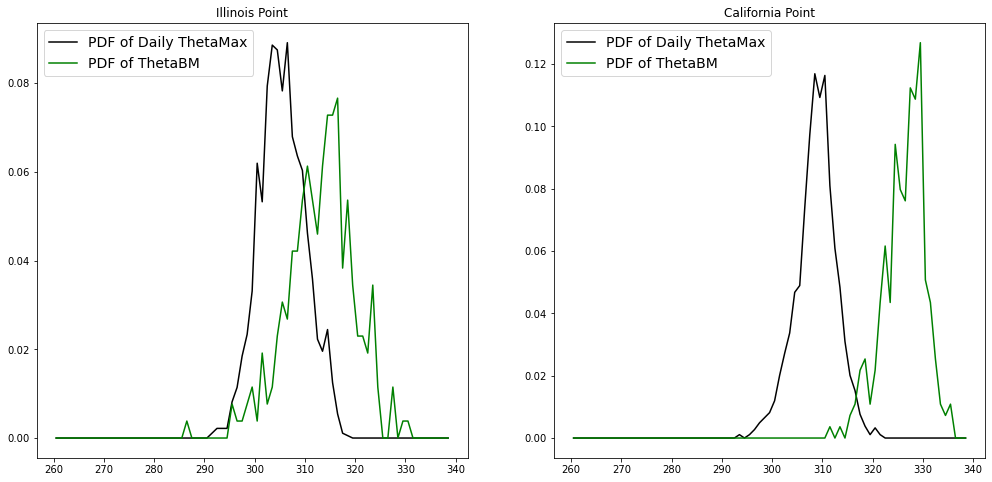

In [188]:
fig, axs = plt.subplots(1,2, figsize=(17, 8))
axs      = axs.ravel()

# Plot distribution of Theta Max at maxed-out region (CO)
axs[0].plot(binCenters, pdf_CLM5[21,41,:],'k-')
axs[0].set_title('Illinois Point')
# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,21,41],bins=binEdges, density=True)
axs[0].plot(binCenters,histPoint_clm5,'g-')
axs[0].legend(['PDF of Daily ThetaMax','PDF of ThetaBM'],fontsize=14)
#axs[0].axvline(318.75+0.25, color='k')


# Plot distributin of Theta Max at not maxed-out region (CA)
axs[1].plot(binCenters,pdf_CLM5[17,16], 'k-')
axs[1].set_title('California Point')
# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,17,16],bins=binEdges, density=True)
axs[1].plot(binCenters,histPoint_clm5,'g-')
axs[1].legend(['PDF of Daily ThetaMax','PDF of ThetaBM'],fontsize=14)



In [189]:
pctDays_CLM5[21,41]

0.855072463768116

In [190]:
ilat = 21
ilon = 41

dataCLM5 = np.squeeze(dailyMax_CLM5_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
[histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)

validCLM5  = np.where(histPoint_clm5>0)[0]
iPeak_clm5  = binCenters[(np.where(histPoint_clm5>0)[0])[-1]]
iMin_clm5   = binCenters[(np.where(histPoint_clm5>0)[0])[0]]
print('Min thetamax bin: ', iMin_clm5)
print('Max thetamax bin: ', iPeak_clm5)

# ---------------------------------
#  Compare thetaBM each day to PDF
# ---------------------------------
for iTime in range(np.shape(thetaBM_CLM5)[0]): 
    thetaBM_CLM5_day  = thetaBM_CLM5[iTime,ilat,ilon]

    if ((len(validCLM5)>0) & (np.isfinite(thetaBM_CLM5_day)==True)): 
        # Assuming binary system...
        if thetaBM_CLM5_day>(iPeak_clm5+binWidth):
            CIplaus_CLM5[iTime, ilat,ilon] = 0 
        elif ( (thetaBM_CLM5_day<=(iPeak_clm5+(binWidth/2))) & (thetaBM_CLM5_day>=(iMin_clm5-(binWidth/2))) ):
            CIplaus_CLM5[iTime, ilat,ilon] = 1
        else:
            CIplaus_CLM5[iTime, ilat,ilon] = -1

        # Assuming we use probability from PDF...
        iBin     = np.where((binCenters>=thetaBM_CLM5_day-0.25) & (binCenters<=thetaBM_CLM5_day+0.25))[0]
        if len(iBin)>0:
            CIplausPct_CLM5[iTime,ilat,ilon] = (histPoint_clm5[iBin]*binWidth)*100
        else:
            CIplausPct_CLM5[iTime,ilat,ilon] = np.nan
                
iPlaus                  = np.where(CIplaus_CLM5[:,ilat,ilon]!=0)[0]
pctDays_CLM5[ilat,ilon] = len(iPlaus)/(np.shape(thetaBM_CLM5)[0])

print('Pct of days where thetaBM falls within thetaMax distribution:   %.3f' % 
      (pctDays_CLM5[ilat,ilon]*100))
print('Mean likelihood of thetaMax where thetaBM is within bin:        %.3f' % 
      np.nanmean(CIplausPct_CLM5[:,ilat,ilon],axis=0))


Min thetamax bin:  291.5
Max thetamax bin:  318.5
Pct of days where thetaBM falls within thetaMax distribution:   85.507
Mean likelihood of thetaMax where thetaBM is within bin:        2.456


In [191]:
np.shape(thetaBM_CLM5[:,ilat,ilon])

(276,)

In [192]:
np.nansum(CIplausPct_CLM5[:,ilat,ilon])/(len(np.where(np.isfinite(CIplausPct_CLM5[:,ilat,ilon])==True)[0]))


2.4564238151194675

In [116]:
histPoint_clm5*binWidth

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00108696, 0.        , 0.00108696,
       0.00108696, 0.00054348, 0.00163043, 0.        , 0.00217391,
       0.00271739, 0.00543478, 0.00326087, 0.00815217, 0.01195

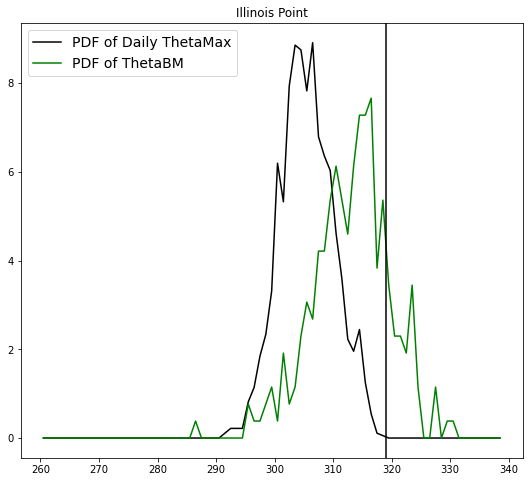

In [195]:
fig, ax1 = plt.subplots(1,1, figsize=(9, 8))

# Plot distribution of Theta Max at maxed-out region (CO)
[histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)
ax1.plot(binCenters, (histPoint_clm5*binWidth*100),'k-')
ax1.set_title('Illinois Point')

# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,ilat,ilon],bins=binEdges, density=True)
ax1.plot(binCenters,(histPoint_clm5*binWidth*100),'g-')
ax1.legend(['PDF of Daily ThetaMax','PDF of ThetaBM'],fontsize=14)
ax1.axvline(iPeak_clm5+(binWidth/2), color='k')



In [194]:
binEnd = np.where(binEdges==iPeak_clm5-(binWidth/2))[0]
binEdges[binEnd]

np.nansum(histPoint_clm5[0:binEnd[0]+1]*binWidth)


0.8352490421455939